## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

Real cameras use curved lenses to form an image, and light rays often bend a little too much or too little at the edges of these lenses. This creates an effect that distorts the edges of images, so that lines or objects appear more or less curved than they actually are. This is called radial distortion, and it’s the most common type of distortion.

Here we will calibrate the camera by calculating the calibration matrix and distortion coefficients.
To do that, we use images taken of a reference pattern, for which we know the non distorted shape and size.
This reference image is a chessboard.

Note: I renamed images 1 to 9 so that they could be sorted by name.

### Detect Corners

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline

def calibrate_camera(debug_plot=False):
    
   # list images to calibrate
    images_format = 'camera_cal/calibration*.jpg'
    images = glob.glob(images_format)
    images = sorted(images)
    print("{} Images found for camera calibration.".format(len(images)))

    # Define Chessboard dimensions
    nx = 9 # number of inside corners in x
    ny = 6 # number of inside corners in y

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if not ret and debug_plot:
            plt.figure()
            plt.imshow(img)
            plt.title("{} -> No Corners Found!".format(fname))
            plt.show()

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

            # Plot only the first
            if debug_plot:
                print("Found corners for {}".format(fname))
                plt.figure()
                plt.imshow(img)
                plt.title("{}".format(fname))
                plt.show()
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return (mtx, dist, rvecs, tvecs)

20 Images found for camera calibration.


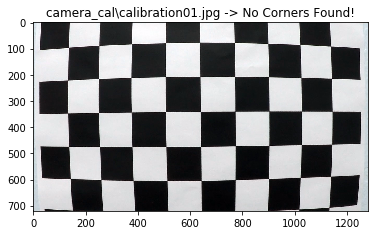

Found corners for camera_cal\calibration02.jpg


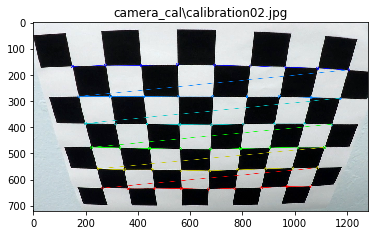

Found corners for camera_cal\calibration03.jpg


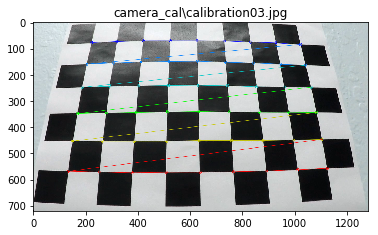

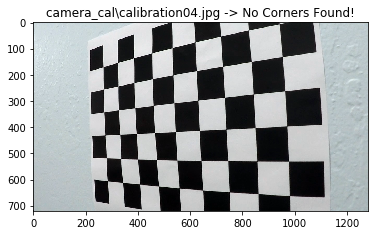

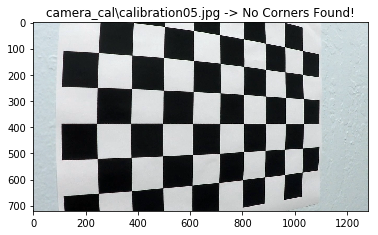

Found corners for camera_cal\calibration06.jpg


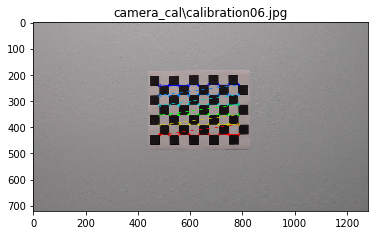

Found corners for camera_cal\calibration07.jpg


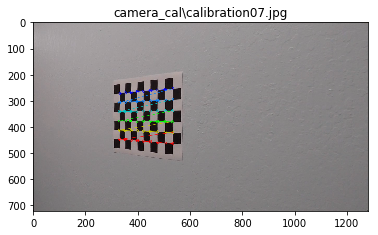

Found corners for camera_cal\calibration08.jpg


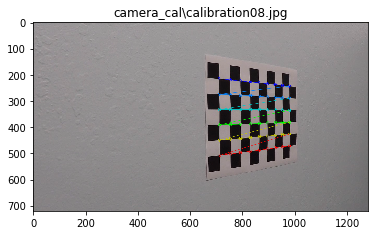

Found corners for camera_cal\calibration09.jpg


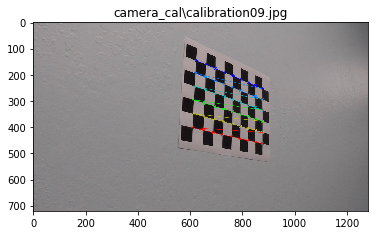

Found corners for camera_cal\calibration10.jpg


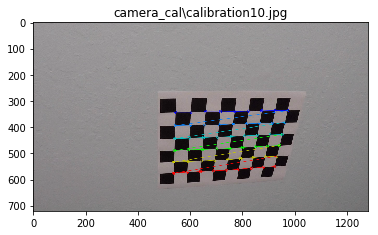

Found corners for camera_cal\calibration11.jpg


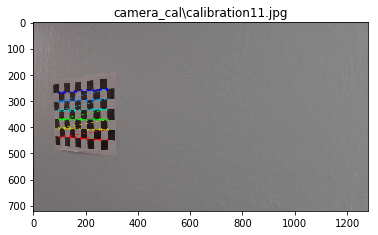

Found corners for camera_cal\calibration12.jpg


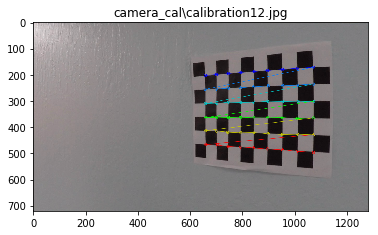

Found corners for camera_cal\calibration13.jpg


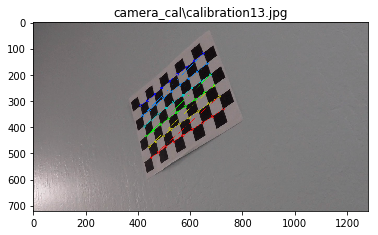

Found corners for camera_cal\calibration14.jpg


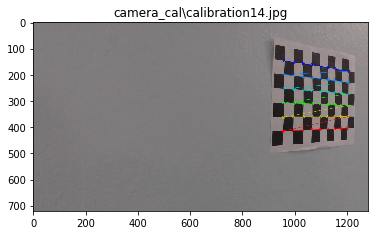

Found corners for camera_cal\calibration15.jpg


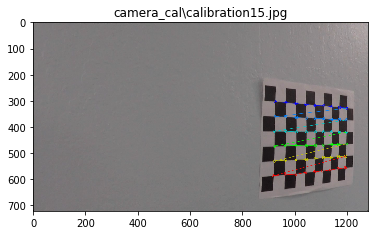

Found corners for camera_cal\calibration16.jpg


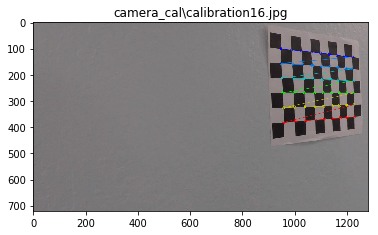

Found corners for camera_cal\calibration17.jpg


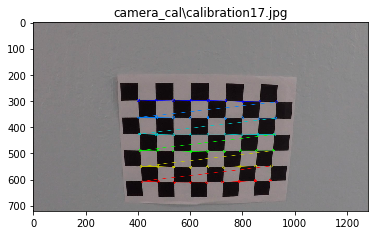

Found corners for camera_cal\calibration18.jpg


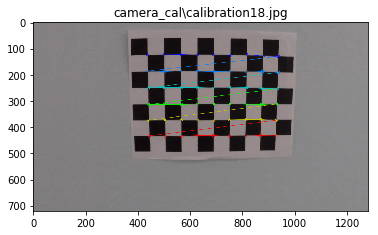

Found corners for camera_cal\calibration19.jpg


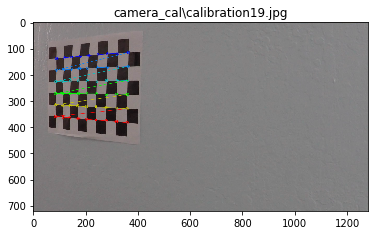

Found corners for camera_cal\calibration20.jpg


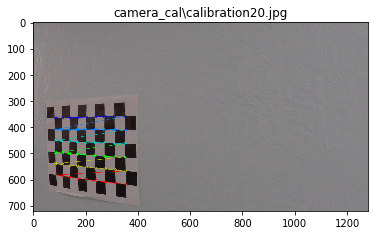

In [4]:
# Calibrate Camera
(mtx, dist, rvecs, tvecs) = calibrate_camera(True)

## Apply Distortion Correction

In [ ]:
def correct_img_distortion(img, mtx, dist):
    """Correct the image distortion represented by the distortion matrix"""
    return cv2.undistort(img, mtx, dist, None, mtx)

In [ ]:
def test_undistortion(images, mtx, dist):
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        undist = correct_img_distortion(img, mtx, dist)

        # Show Both images
        print('Undistortion for {}'.format(fname))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
        
# Test Distortion Correction on chessboard images
images_format = 'camera_cal/calibration*.jpg'
images = glob.glob(images_format)
images = sorted(images)
print("Number of images: {}".format(len(images)))
test_undistortion(images, mtx, dist)
        

## Apply Binary Transform

In [118]:
import os

def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, thresh=(0,255)):
    """Apply binary threshold to either the X or Y gradient.
       Expects grayscale input image."""

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_threshold(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    """Apply binary threshold to the gradient magnitude.
    Expects grayscale input image."""

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh_deg=(0, 90)):
    """Apply binary treshold to the gradient direction. Threshold expected in degrees.
       Expects grayscale input image."""

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_deg[0]*np.pi/180) & (absgraddir <= thresh_deg[1]*np.pi/180)] = 1

    # Return the binary image
    return binary_output

def grad_threshold(gray, kernel_size=3, thresholds={}, debug_plot=False):
    """Combine gradient magnitude, X/Y gradients and the gradient direction to form a binary image.
       Expects Gray input image."""
    gradx_thresh = thresholds.get('gradx', (0, 255))
    grady_thresh = thresholds.get('grady', (0, 255))
    mag_thresh = thresholds.get('mag', (0, 255))
    dir_thresh = thresholds.get('dir', (0, 90))
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(gray, orient='x', sobel_kernel=kernel_size, thresh=gradx_thresh)
    grady = abs_sobel_threshold(gray, orient='y', sobel_kernel=kernel_size, thresh=grady_thresh)
    mag_binary = mag_threshold(gray, sobel_kernel=kernel_size, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(gray, sobel_kernel=kernel_size, thresh_deg=dir_thresh)
    
    # Combine maps
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if debug_plot:

        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 10))
        f.tight_layout()
        ax1.imshow(gray, cmap='gray')
        ax1.set_title('Gray Image', fontsize=10)
        ax2.imshow(gradx, cmap='gray')
        ax2.set_title('Thresholded Gradient X', fontsize=10)
        ax3.imshow(grady, cmap='gray')
        ax3.set_title('Thresholded Gradient Y', fontsize=10)
        ax4.imshow(mag_binary, cmap='gray')
        ax4.set_title('Thresholded Magnitude', fontsize=10)
        ax5.imshow(dir_binary, cmap='gray')
        ax5.set_title('Thresholded Grad. Dir.', fontsize=10)
        ax6.imshow(combined, cmap='gray')
        ax6.set_title('Combined', fontsize=10)
        plt.subplots_adjust(left=0.1, right=0.6, top=0.9, bottom=0.1)
        plt.show()
    
    return combined

def color_threshold(img_bin, thresh=(0, 255), debug_plot=False, debug_title=''):
    """Apply binary threshold to a grayscale image"""

    # Threshold color channel
    res = np.zeros_like(img_bin)
    res[(img_bin >= thresh[0]) & (img_bin <= thresh[1])] = 1

    if debug_plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        f.tight_layout()
        ax1.imshow(img_bin, cmap='gray')
        ax1.set_title(debug_title, fontsize=10)
        ax2.imshow(res, cmap='gray')
        ax2.set_title('Color Threshold', fontsize=10)
        plt.subplots_adjust(left=0.1, right=0.6, top=0.9, bottom=0.1)
        plt.show()
    
    return res

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def do_binary_thresholding(img_rgb, thresholds, kernal_size, debug_plot=False):
    
    
    # For this thresholding technique, we will try to find yellow and white lines using different techniques
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    h_chan = img_hls[:,:,0]
    l_chan = img_hls[:,:,1]
    s_chan = img_hls[:,:,2]
       
    h_bin = color_threshold(h_chan, thresholds['h'], False, 'Hue Channel')
    l_bin = color_threshold(l_chan, thresholds['l'], False, 'L Channel')
    s_bin = color_threshold(s_chan, thresholds['sat'], False, 'Saturation Channel')
    
    ls_bin = np.zeros_like(h_bin)
    ls_bin[(l_bin == 1) | (s_bin == 1)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(ls_bin)
    combined_binary[(h_bin == 1) | (ls_bin == 1)] = 1
    
    # Apply Masking to remove unwanted elements
    x_size = img_rgb.shape[1]
    y_size = img_rgb.shape[0]
    vertices = np.array([[
         (100, y_size),     # Bottom Left
         (500, 450),        # Top Left
         (800, 450),        # Top Right
         (1200, y_size)      # Bottom Right
         ]], dtype=np.int32)
    output_img = region_of_interest(combined_binary, vertices)
    
    # Plotting thresholded images
    if debug_plot:

        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
        ax1.set_title('Original')
        ax1.imshow(img_rgb)

        ax2.set_title('Hue Threshold')
        ax2.imshow(h_bin, cmap='gray')
        
        ax3.set_title('S+L Threshold')
        ax3.imshow(ls_bin, cmap='gray')

        ax4.set_title('Output (After mask)')
        ax4.imshow(output_img, cmap='gray')

        plt.show() 
    
    return output_img
    

Found 8 test images for lane detection
test_images\straight_lines1.jpg
Final Result


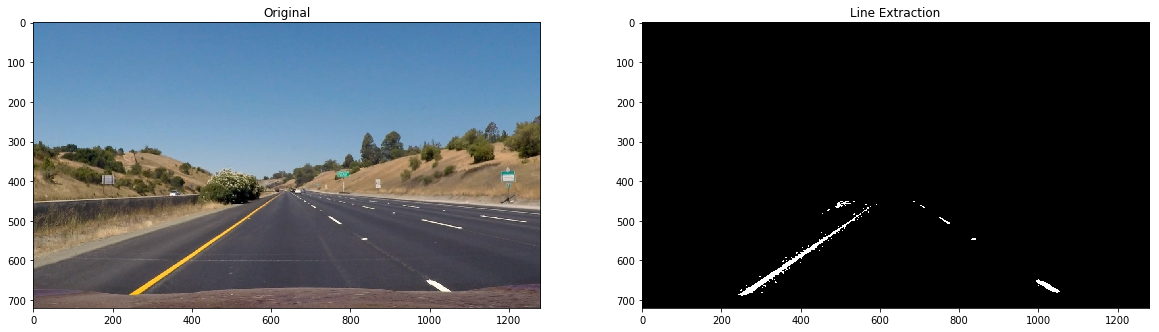

output_images/binary/bin_straight_lines1.jpg
test_images\straight_lines2.jpg
Final Result


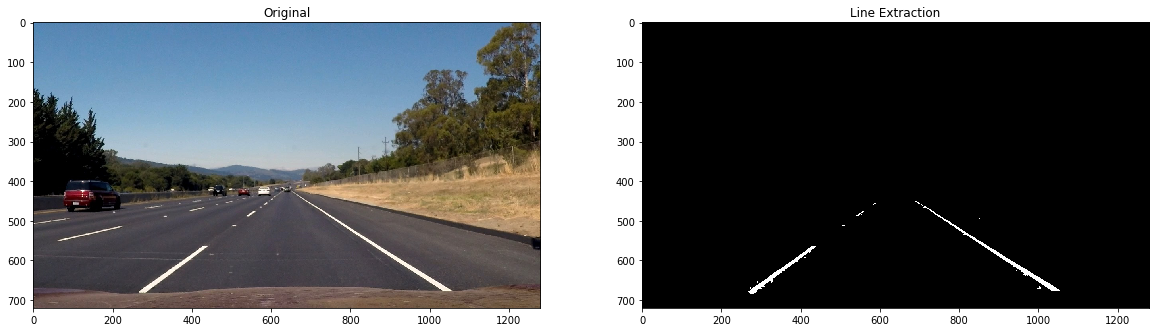

output_images/binary/bin_straight_lines2.jpg
test_images\test1.jpg
Final Result


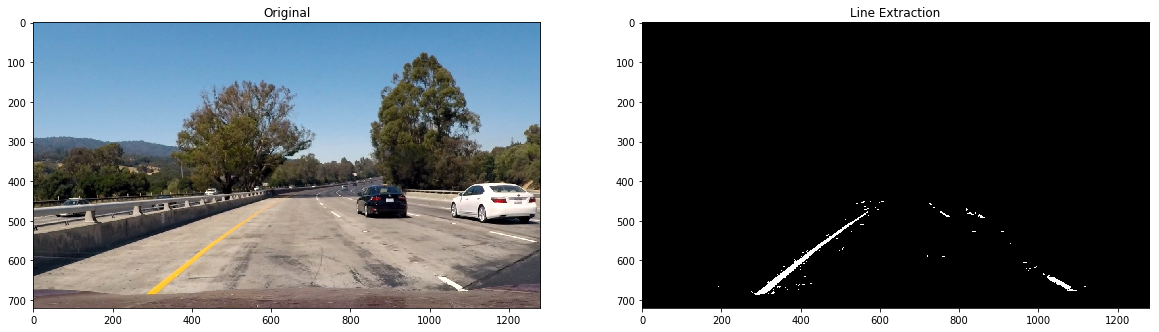

output_images/binary/bin_test1.jpg
test_images\test2.jpg
Final Result


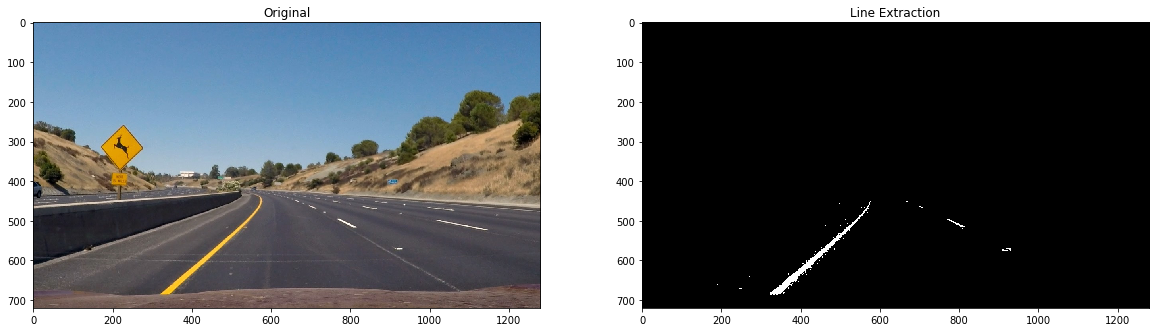

output_images/binary/bin_test2.jpg
test_images\test3.jpg
Final Result


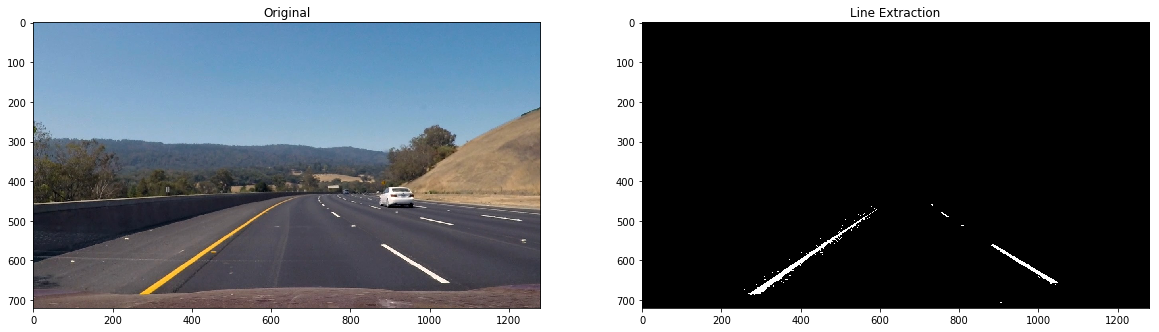

output_images/binary/bin_test3.jpg
test_images\test4.jpg
Final Result


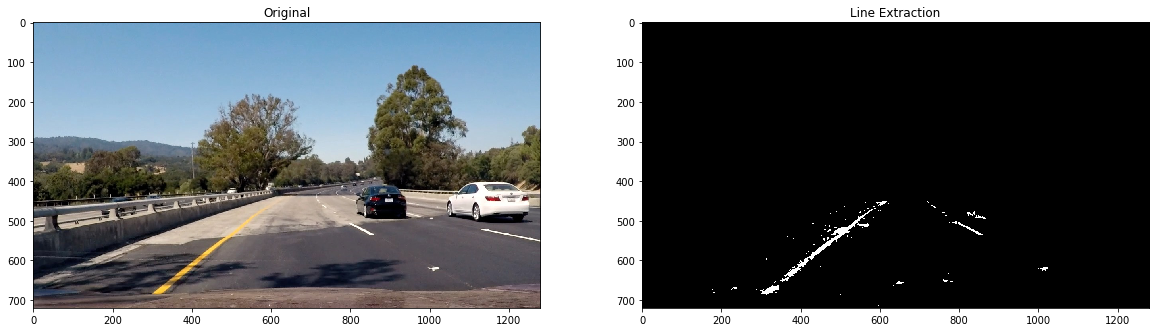

output_images/binary/bin_test4.jpg
test_images\test5.jpg
Final Result


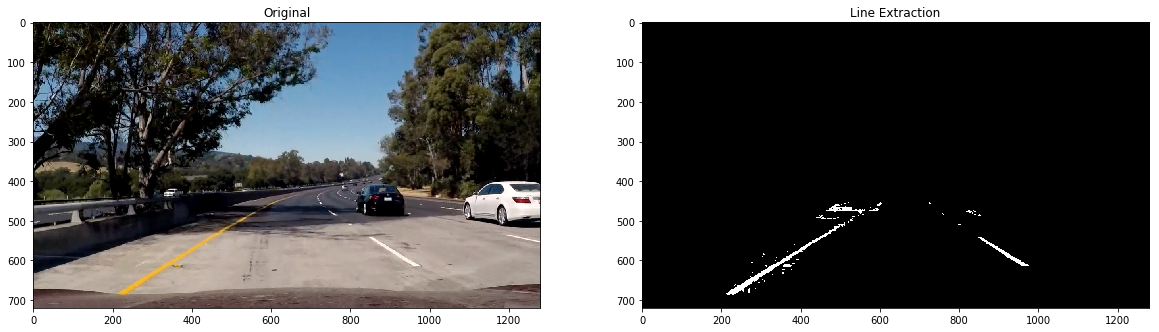

output_images/binary/bin_test5.jpg
test_images\test6.jpg
Final Result


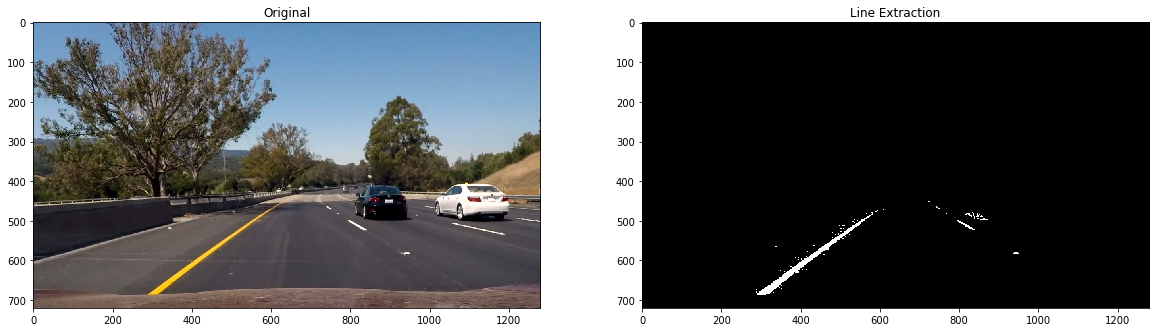

output_images/binary/bin_test6.jpg


In [119]:
def run_binary_thresholds(test_images, thresholds, kernel_size, debug_plot=False):

    # Run the thresholding on all images
    for image in test_images:
        
        print('{}'.format(image))
        
        # Read image and convert
        img_bgr = cv2.imread(image)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Get Binary treshold
        combined_binary = do_binary_thresholding(img_rgb, thresholds, kernel_size)
        
        # Plot Original image and result side by side
        print('Final Result')
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.set_title('Original')
        ax1.imshow(img_rgb)
        
        ax2.set_title('Line Extraction')
        ax2.imshow(combined_binary, cmap='gray')
        plt.show()  
        
        # Save Image to file
        binary_scaled = combined_binary * 255
        file_name = os.path.basename(image)
        output_file = 'output_images/binary/bin_' + file_name
        print(output_file)
        cv2.imwrite(output_file, binary_scaled)
        

# Filename of the test image
images_format = 'test_images/*.jpg'
images = glob.glob(images_format)
print("Found {} test images for lane detection".format(len(images)))

# Define Thresholds (dir in degrees, rest in pix value)
thresholds = {'gradx':(20,100), 'grady':(20,100), 'mag':(30,100), 'dir':(40,80), 'sat':(180,255), 'h':(20,25), 'l':(200,255)}
kernel_size = 3

# Run threshold test on test images
run_binary_thresholds(images, thresholds, kernel_size, True)

output_images/video/test_images\frame_609.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


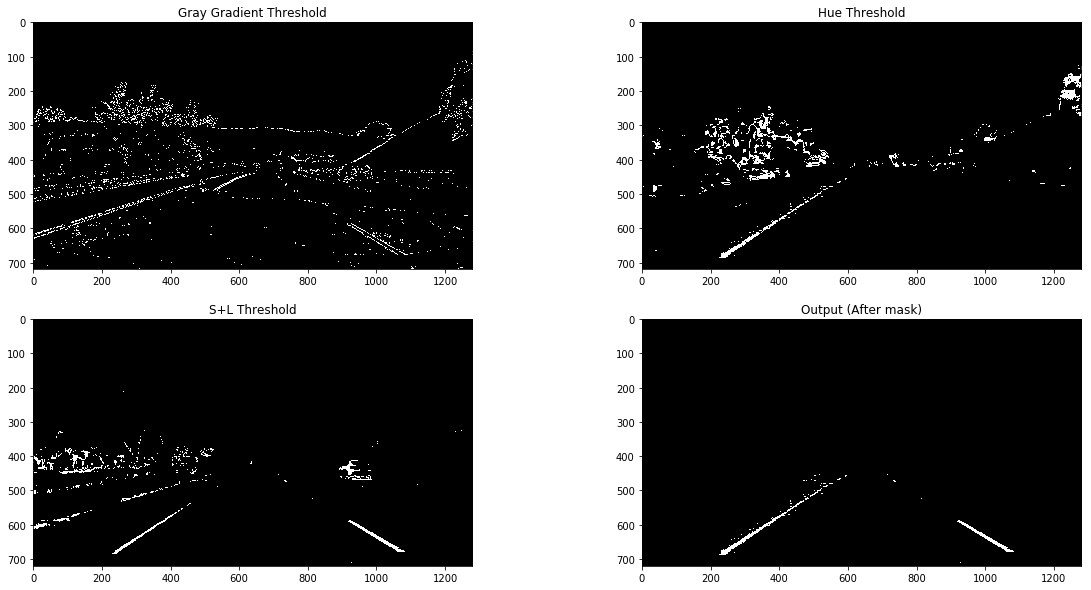

Final Result


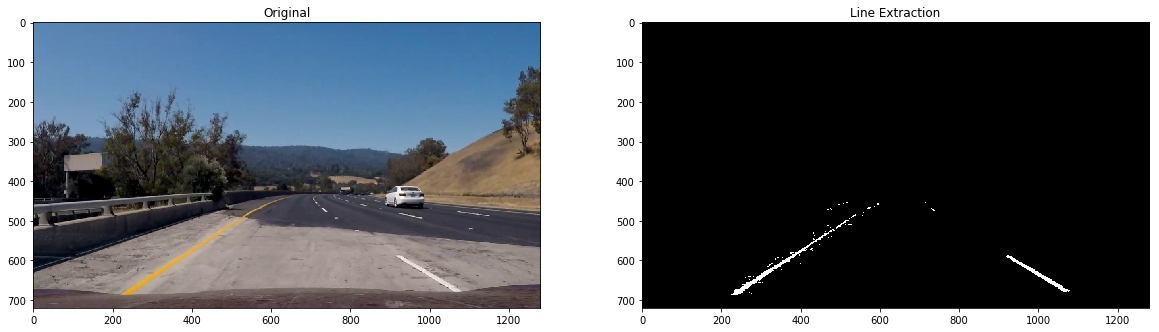

output_images/binary/bin_frame_609.jpg
output_images/video/test_images\frame_610.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


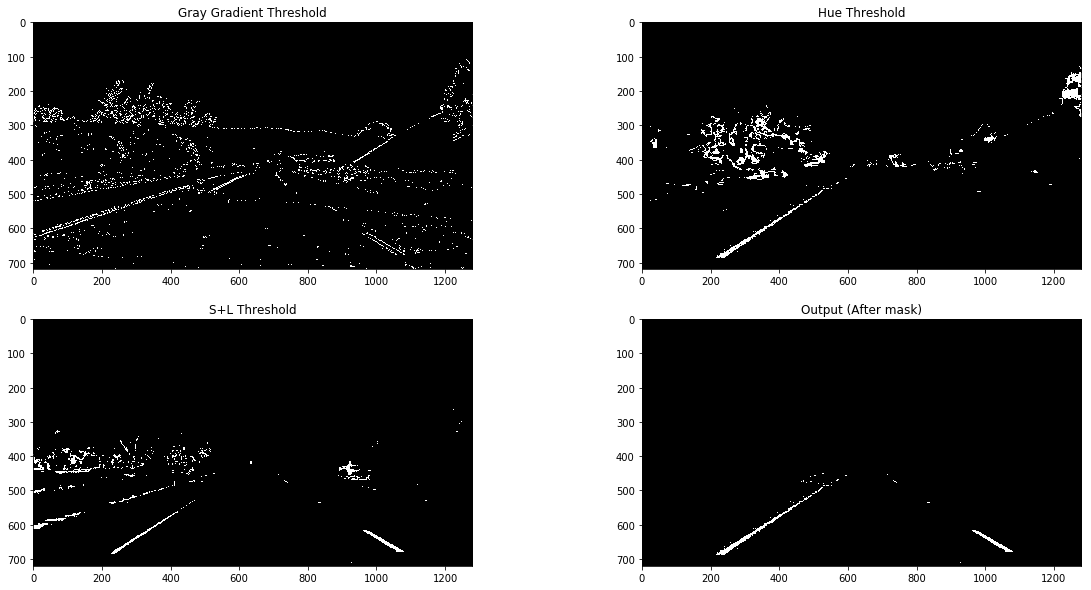

Final Result


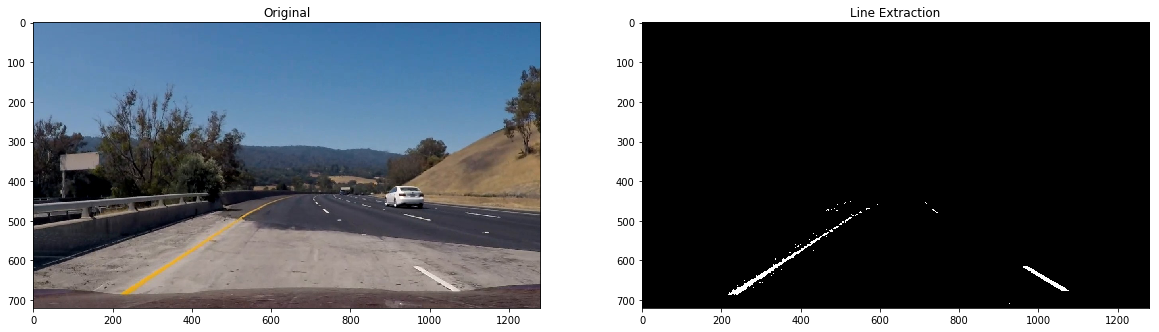

output_images/binary/bin_frame_610.jpg
output_images/video/test_images\frame_611.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


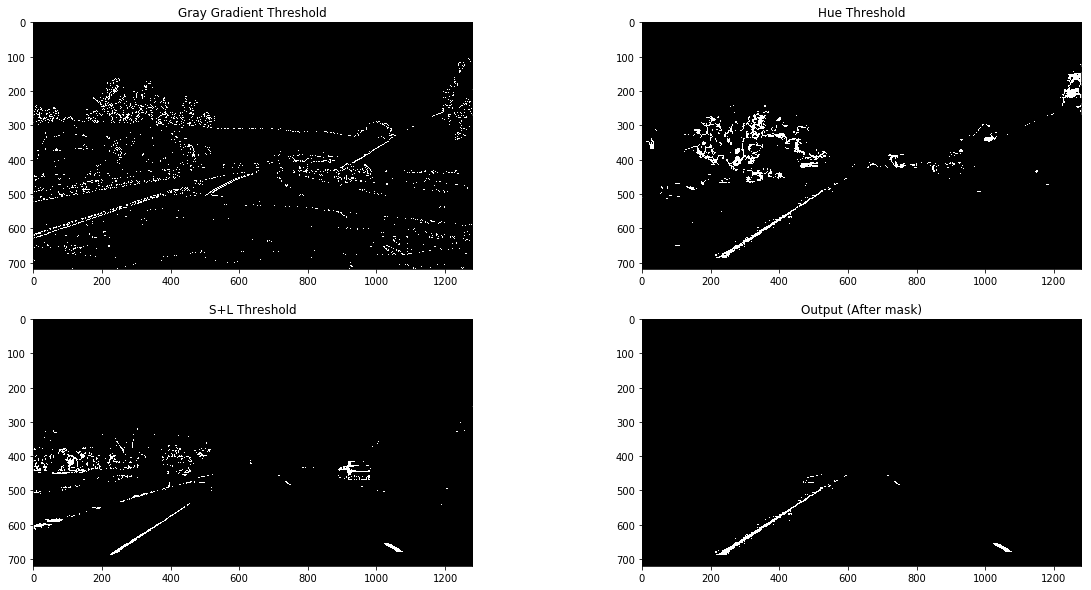

Final Result


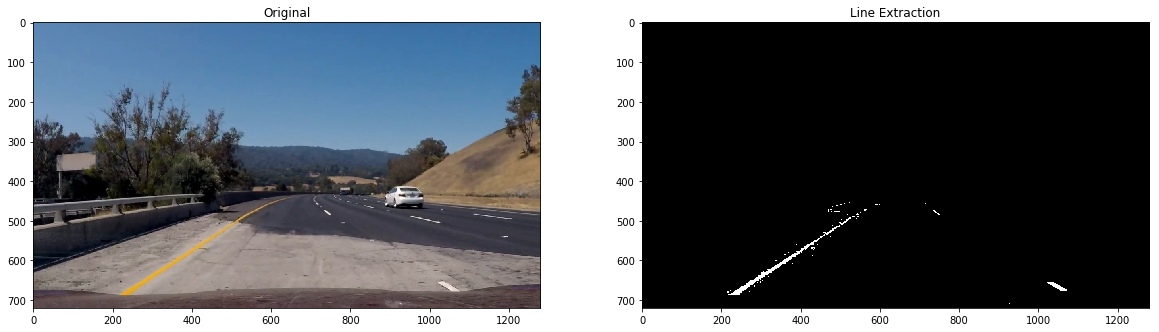

output_images/binary/bin_frame_611.jpg
output_images/video/test_images\frame_612.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


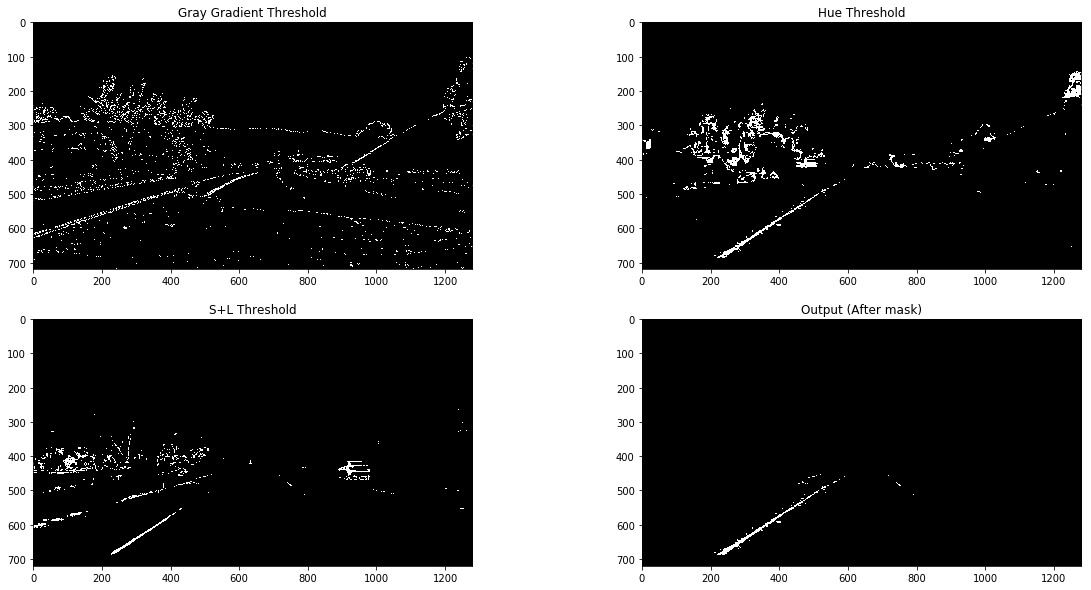

Final Result


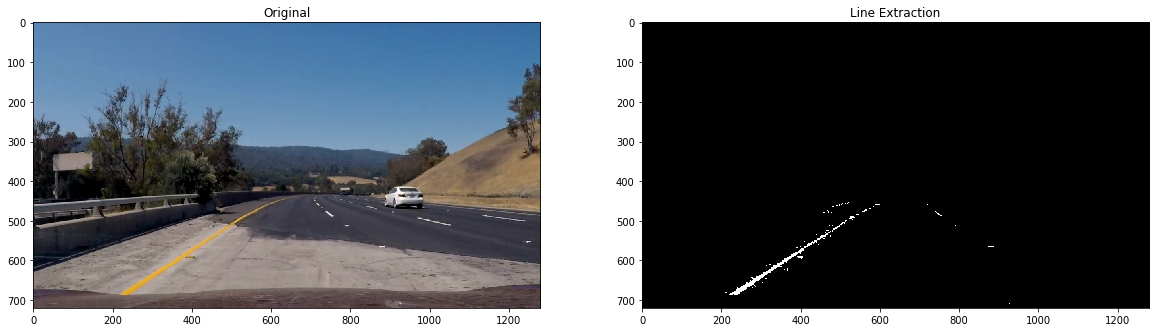

output_images/binary/bin_frame_612.jpg
output_images/video/test_images\frame_613.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


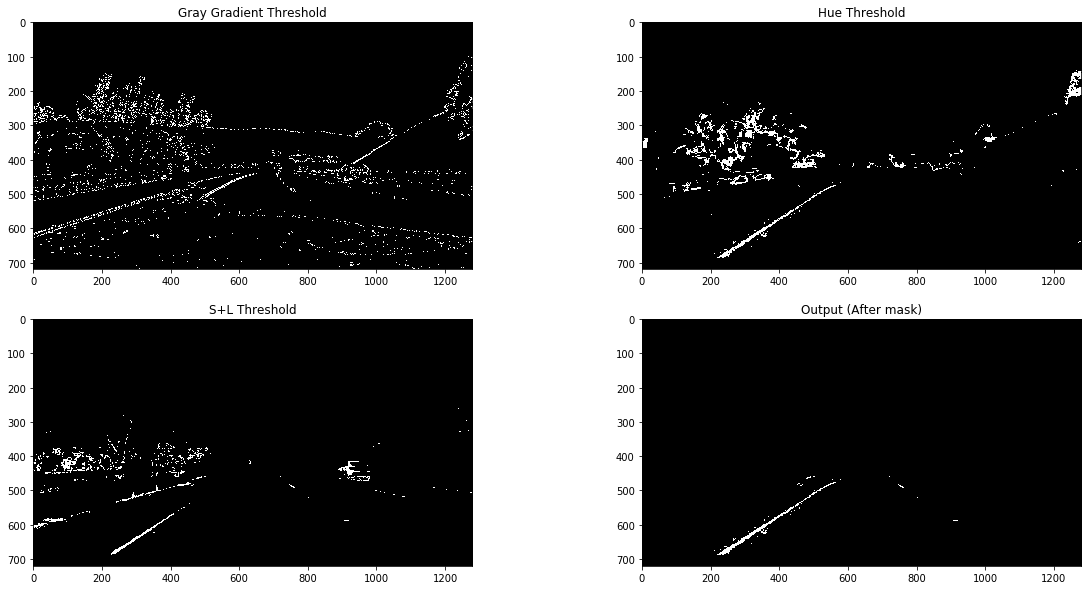

Final Result


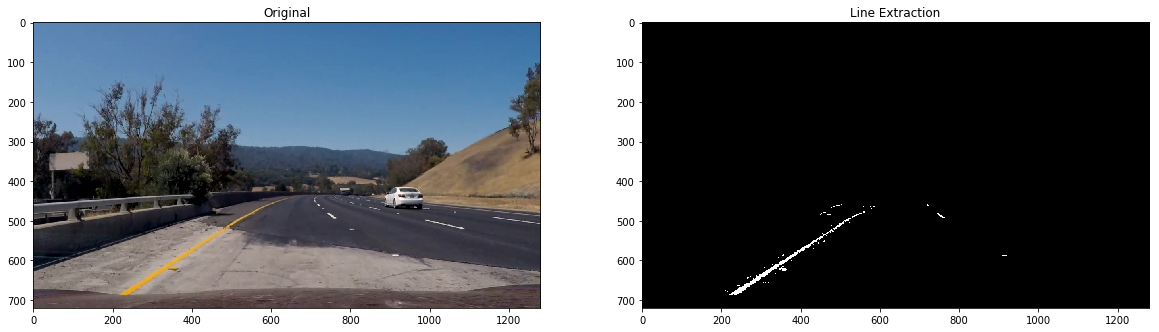

output_images/binary/bin_frame_613.jpg
output_images/video/test_images\frame_614.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


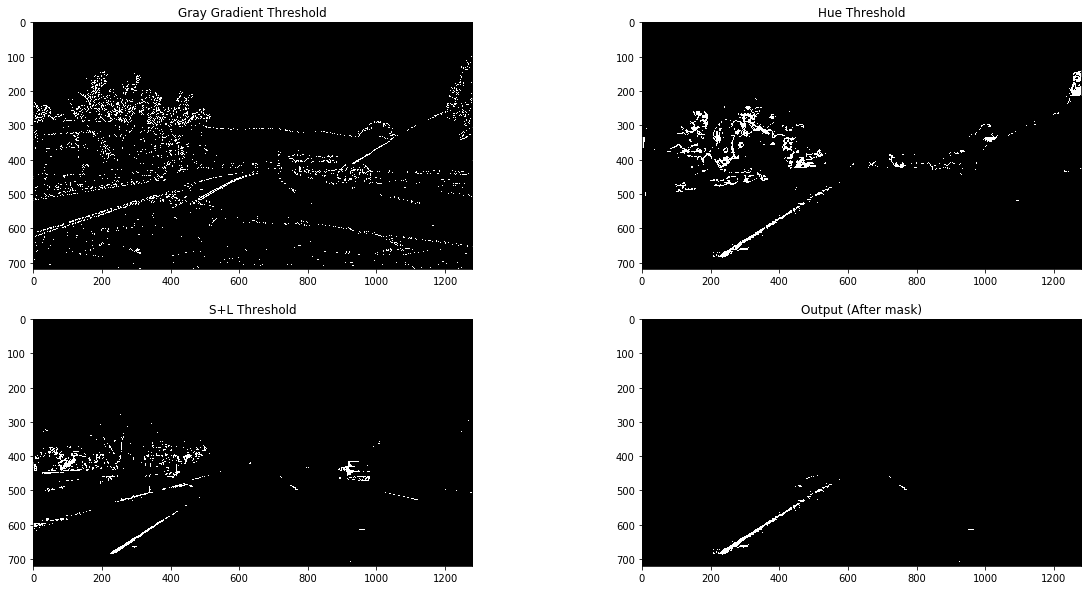

Final Result


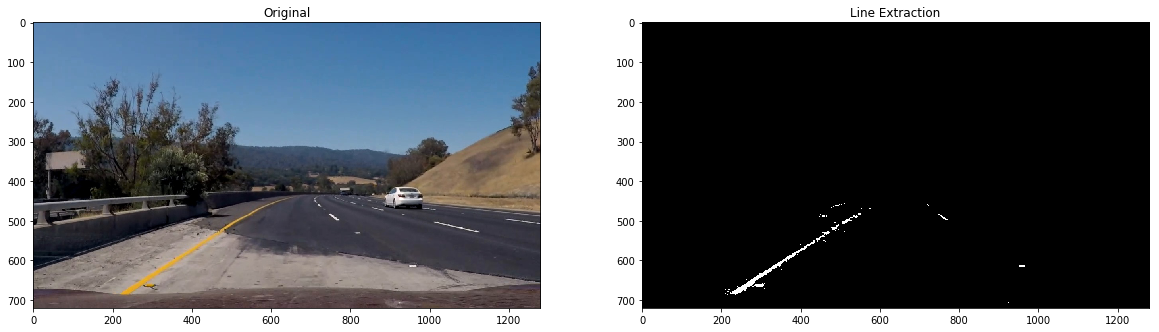

output_images/binary/bin_frame_614.jpg
output_images/video/test_images\frame_615.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


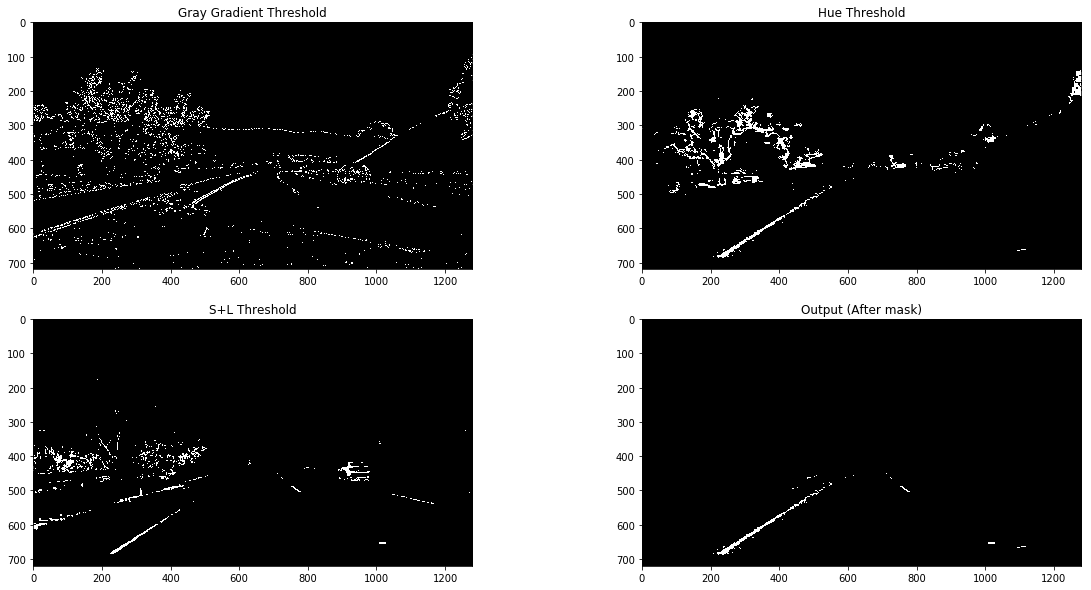

Final Result


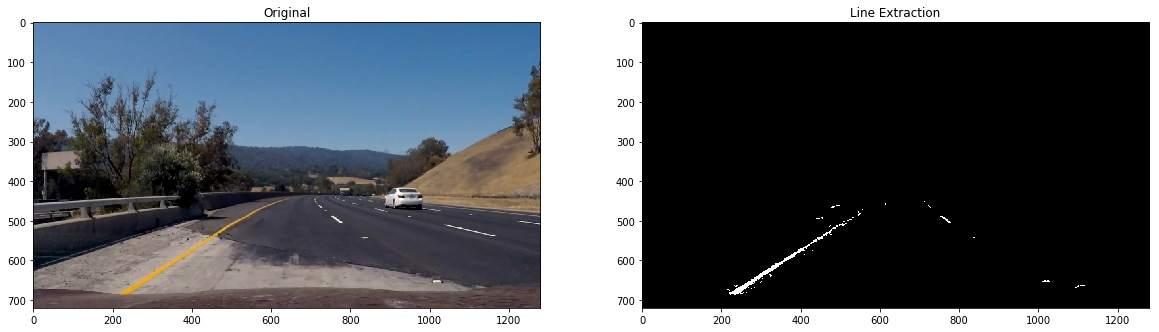

output_images/binary/bin_frame_615.jpg
output_images/video/test_images\frame_616.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


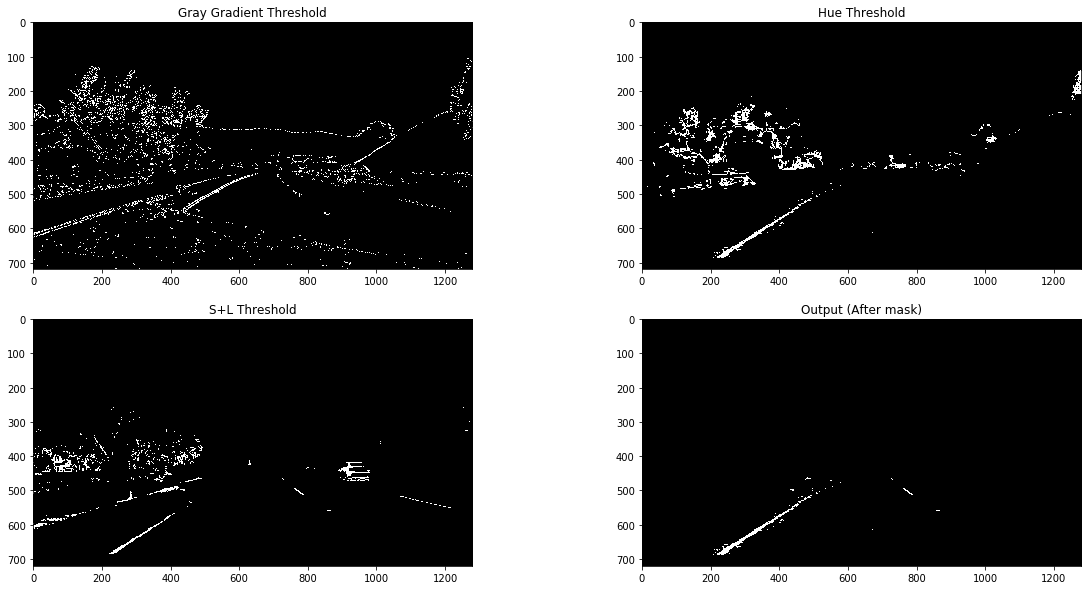

Final Result


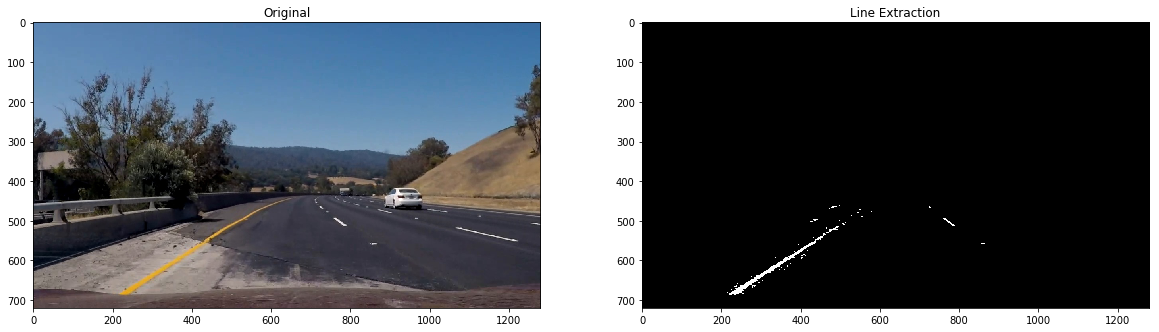

output_images/binary/bin_frame_616.jpg
output_images/video/test_images\frame_617.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


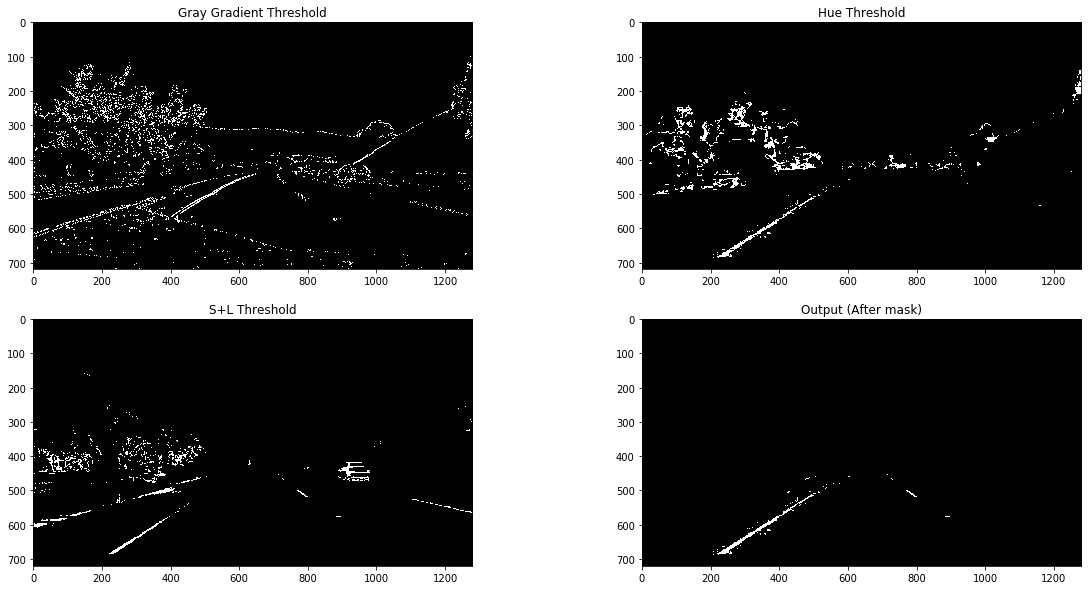

Final Result


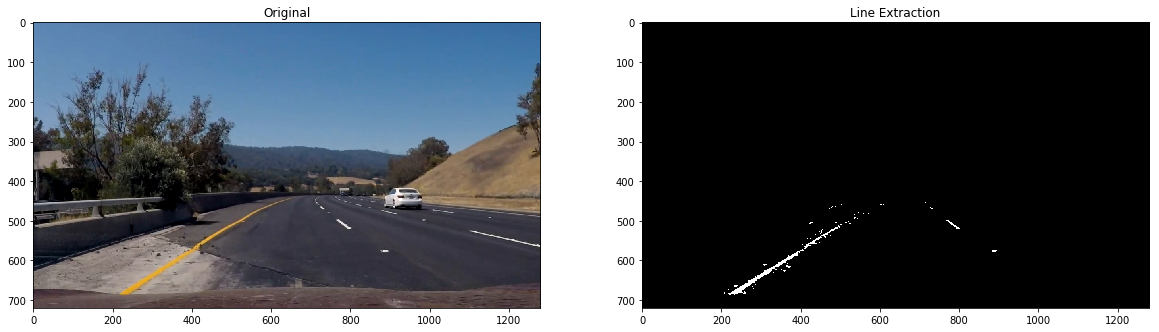

output_images/binary/bin_frame_617.jpg
output_images/video/test_images\frame_618.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


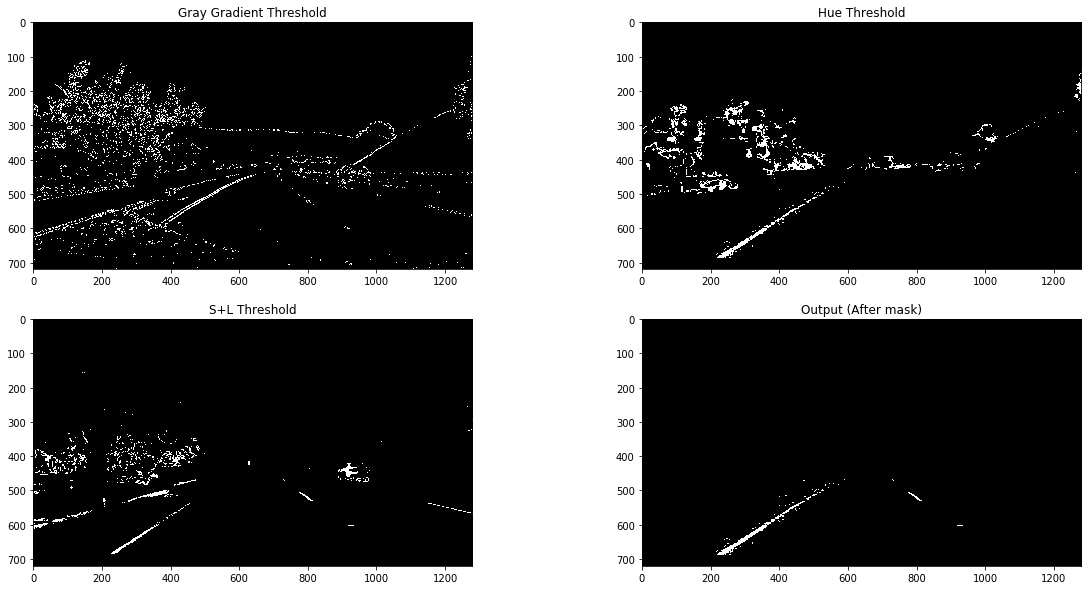

Final Result


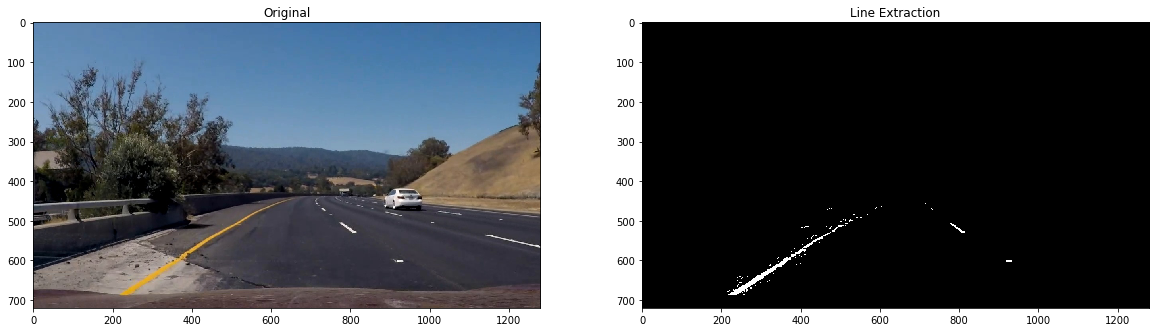

output_images/binary/bin_frame_618.jpg
output_images/video/test_images\frame_619.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


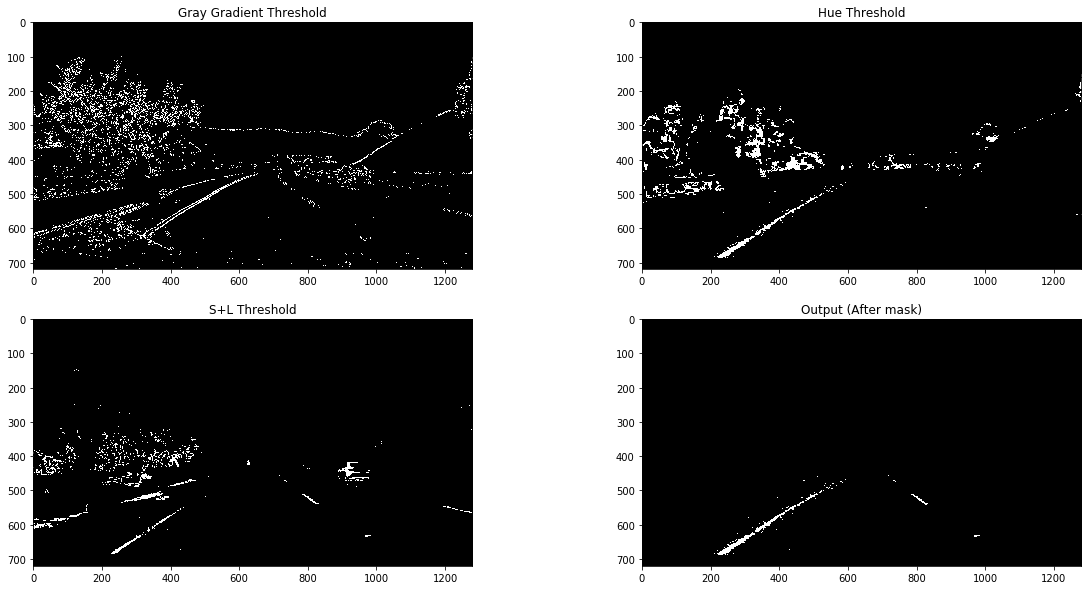

Final Result


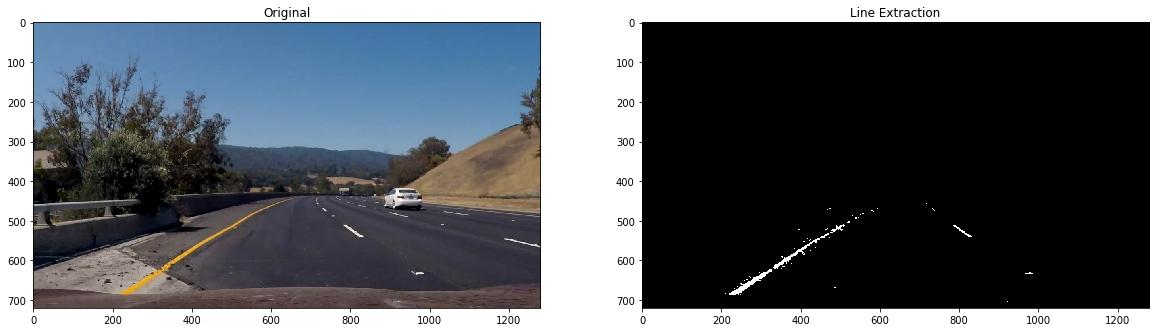

output_images/binary/bin_frame_619.jpg
output_images/video/test_images\frame_620.jpg
Gray Image Gradient
Hue Channel
L Channel
Saturation Channel
S + L Channels


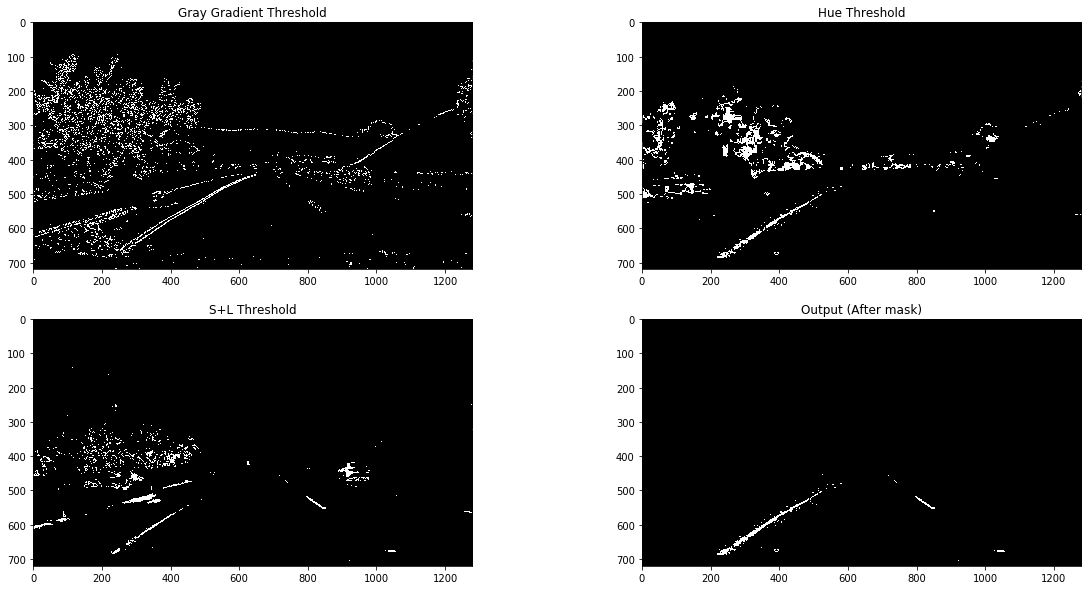

Final Result


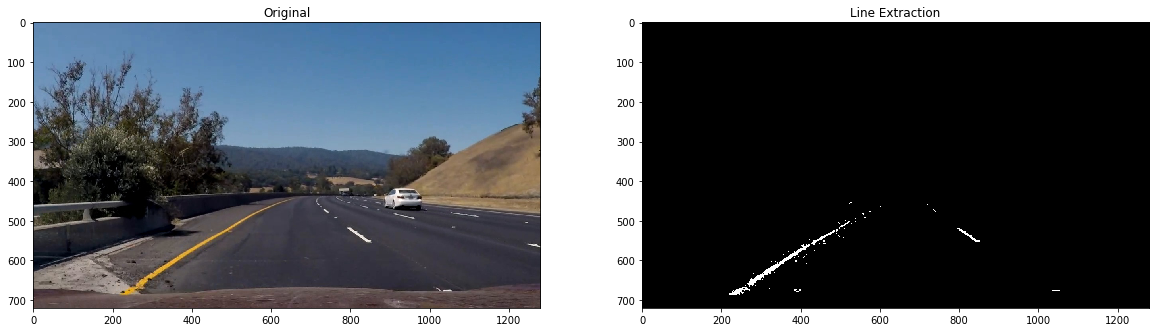

output_images/binary/bin_frame_620.jpg


In [116]:
# Run on images from the video
images_format = 'output_images/video/test_images/*.jpg'
images = glob.glob(images_format)

# Define Thresholds (dir in degrees, rest in pix value)
thresholds = {'gradx':(20,100), 'grady':(20,100), 'mag':(30,100), 'dir':(40,80), 'sat':(180,255), 'h':(20,25), 'l':(200,255)}
kernel_size = 3

# Run threshold test on test images
run_binary_thresholds(images, thresholds, kernel_size, True)

## Rectify binary image using Perspective Transform

The goal here is to produce a top-down view of the image, so that we can later on calculate the curvature of the lane.
We are basically try to move the camera at the vertical position, pointing down to the road (like a bird view of the road)
To do this we'll use opencv's getPerspectiveTransform and warpPerspective, with a source polygon and destination polygon.
The source and destination polygons represent the same physical coordinates, but for 2 different positions of the camera.

In [ ]:
def transform_img_perspective(img, M, width, height):
    """Transforms an image such that we are always viewing objects from the same angle
    The input image must be undistorted"""
    # Warp your image to a top-down view
    return cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)

def get_transform_matrix(src, dst):
    return cv2.getPerspectiveTransform(src, dst)

def get_src_dst_polygons(height=720.0, width=1280.0, dst_margin=350.0):
    """Define source and destination polygons based on measurements from test images."""
   
    # Define Source points as a trapeozidal shape, representating a section of road on the original camera view
    src = np.float32([
        [206, 720],
        [583, 460], 
        [703, 460],
        [1100, 720] ])
        
    # Destinations points represent the same sections of road, but on a bird-eye view, so it's a rectangle
    dst = np.float32([
        [dst_margin, height],
        [dst_margin, 0.0],
        [width-dst_margin, 0.0],
        [width-dst_margin, height]])
    
    return (src, dst)

In [ ]:
def run_perspective_correction(images, mtx, dist, is_gray=True):
    """Correct the perspective of the road images"""

    # Parameters
    height=720.0
    width=1280.0
    dst_polygon_margin=350.0
    
    # Get source and destination polygons
    (src, dst) = get_src_dst_polygons(height, width, dst_polygon_margin)
    
    # Calculate Transform Matrix
    M = get_transform_matrix(src, dst)
    
    # Extract x/y for plotting
    x_src = [corner[0] for corner in src]
    y_src = [corner[1] for corner in src]
    x_dst = [corner[0] for corner in dst]
    y_dst = [corner[1] for corner in dst]
    
    for idx, fname in enumerate(images):

        img = cv2.imread(fname)
        if is_gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Correct the camera distortion
        img_undist = correct_img_distortion(img, mtx, dist)
        height, width = img.shape[0], img.shape[1]
        
        # Save Image to file
        file_name = os.path.basename(fname)
        file_name_no_ext = file_name.split('.')[0]
        output_file = 'output_images/undistorted/' + file_name
        cv2.imwrite(output_file, img_undist)
        
        # Transform the image perfective from the original camera view to a bird-eye view
        img_birdeye = transform_img_perspective(img_undist, M, width, height)

        # Plot the corrected version
        print("Image correction for {}".format(fname))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img_undist, cmap='gray')
        ax1.plot(x_src, y_src, linestyle='-', marker='.', color='r', markersize=20)
        ax1.set_title('Undistorted Image (Original Perspective)', fontsize=25)
        ax2.imshow(img_birdeye, cmap='gray')
        ax2.plot(x_dst, y_dst, linestyle='-', marker='.', color='r', markersize=20)
        ax2.set_title('Warped Image (Bird-eye Perspective)', fontsize=25)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
        # Save Image to file
        if np.max(img_birdeye) == 1:
            img_birdeye = img_birdeye * 255
        file_name = os.path.basename(fname)
        output_file = 'output_images/warped/' + file_name
        cv2.imwrite(output_file, img_birdeye)
    
    
# Run Perspective correction on binary images
bin_images_format = 'output_images/binary/*.jpg'
bin_images = glob.glob(bin_images_format)
print("Found {} test images for lane detection".format(len(bin_images)))
run_perspective_correction(bin_images, mtx, dist)

# Run Perspective correction on RGB images
rgb_images_format = 'test_images/*.jpg'
rgb_images = glob.glob(rgb_images_format)
#run_perspective_correction(rgb_images, mtx, dist, False)

In [ ]:
def test_perspective_correction_chessboard(images, mtx, dist):
    """Tests perspective correction on the checkboard images"""
    
    for idx, fname in enumerate(images):
                
        img = cv2.imread(fname)
        img_undist = correct_img_distortion(img, mtx, dist)

        # Convert to grayscale
        gray = cv2.cvtColor(img_undist, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret:
            # Define 4 source points: We choose the corner points for the chessboard
            src = np.array([corners[0][0], 
                            corners[nx-1][0],
                            corners[len(corners)-1][0],
                            corners[len(corners)-nx][0]])
            x_src = [corner[0] for corner in src]
            y_src = [corner[1] for corner in src]

            # Define 4 destination points: Corner points if the chessboard was shown as top-view.
            height, width = img.shape[0], img.shape[1]
            margin = width/10
            dst = np.float32([[margin, margin],
                             [width-margin, margin],
                             [width-margin, height-margin],
                             [margin, height-margin]])
            x_dst = [corner[0] for corner in dst]
            y_dst = [corner[1] for corner in dst]

            # Correct the perspective
            (warped, M) = correct_img_perspective(img_undist, src, dst, width, height)

            # Plot the corrected version
            print("Image correction for {}".format(fname))
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img_undist)
            ax1.plot(x_src, y_src, linestyle='None', marker='.', color='r', markersize=20)
            ax1.set_title('Undistorted Image', fontsize=25)
            ax2.imshow(warped)
            ax2.plot(x_dst, y_dst, linestyle='None', marker='.', color='r', markersize=20)
            ax2.set_title('Warped Image', fontsize=25)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
            
            
# Test Perspective rectification on the chessboard images
#test_perspective_correction_chessboard(cal_images, mtx, dist)

## Detect Lane Pixels

Now that we have a pretty clear top-view of the road, we need to find the pixels composing the left and right line of the current lane we are driving in.
We will try to use the simple technique described in the project presentation, which is to break the image in different stripes.
Then in each stripe, we sum the number of white pixels per column, and  find the column that contains the most number of pixels.
This column will give us the x coordinate of a point that should be located right on the line.
We will start our search from the bottom of the image, which is where the lanes are the most clearly defined.

In addition to that, instead of using the entire stripe, we will mask the edges of each stripe to avoid the detection of false positives.
Since some of the line are not plain and break into small sections, some of the stripes will actually not contain any detectable line. To avoid doing false detections on those segments, we define a minimum number of white pixel to be find per column to say that a line was detected. If no line was detected, then we won't use this segment for curve fitting.

In [ ]:
class Line:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
def find_line_center(stripe, min_pix):
    """Finds the x coordinate of the biggest block of white pixels in a stripe.
        To avoid detecting false positives, we set a minimum number of pixels that should be detected to consider the actual center."""

    # We want to find the center of the line.
    # To do that we first sum the pixels per columm, giving us a profile of the road where there are the most white pixels.
    # Then the idea is to find the section that corresponds to the line.
    # 
    # To remove anomalities in the detection, we first compute a moving average of the profile.
    # The number of pixels used for average is set to 50 pixels, which is approximately the theoretical width of a lane.
    # Then to make sure we found a lane, we find the first maximum in the profile, and make sure this maximum is high enough to consider it a lane.
    # Then we calculate the width of the detected lane, and compute the real center.

    # Sum values in each column: gives us an histogram of the white pixels
    hist = np.sum(stripe, axis=0)

    # Run a moving average to get a smoother line detection
    mva_px = 30
    mva_start = int(mva_px/2)
    hist_mva = []
    for n in range(0, len(hist) - mva_px):
        hist_mva.append(np.mean(hist[n:n+mva_px]))
    hist_mva = np.array(hist_mva)

    # Find max value
    max_val = np.max(hist)
    max_val_mva = np.max(hist_mva)

    # If we have not detected enough white pixels, it's probably because there is no line in that stripe.
    # In that case, return None.
    x_max = None
    x_max_mva = None
    if max_val_mva >= min_pix:
        # Find the index of this maximum
        x_max = np.argmax(hist)
        x_max_mva = np.argmax(hist_mva)

        # Calculate the width of the lane
        # Find Left Bound
        left_idx = x_max_mva
        cur_val = max_val_mva
        while cur_val > (max_val_mva - 1) and left_idx > 0:
            left_idx -= 1
            cur_val = hist_mva[left_idx]

        # Find Right Bound
        right_idx = x_max_mva
        cur_val = max_val_mva
        while cur_val > (max_val_mva - 1) and right_idx < len(hist_mva) - 1:
            right_idx += 1
            cur_val = hist_mva[right_idx]

        # True Center
        x_center = left_idx + (right_idx - left_idx) / 2
        x_center_val = hist_mva[int(x_center)]

        # The moving average shifts the center
        x_max_mva = np.argmax(hist_mva) + int(mva_px/2)
        x_center = x_center + int(mva_px/2)

    
    debug_plot = False
    if debug_plot:
        f, ax1 = plt.subplots(1, 1, figsize=(16, 8))
        f.tight_layout()
        ax1.set_title('Histogram', fontsize=10)
        ax1.plot(np.arange(0, len(hist)), hist)
        if x_max:
            ax1.plot(x_max, max_val, linestyle='None', marker='.', markersize=15)

        ax1.plot(np.arange(int(mva_px/2), len(hist_mva) + int(mva_px/2)), hist_mva)
        if x_max_mva:
            ax1.plot(x_max_mva, max_val_mva, linestyle='None', marker='.', markersize=15)
            ax1.plot(x_center, x_center_val, linestyle='None', marker='.', markersize=15)

        plt.show()
    
    return x_max_mva
    
def find_lines(image, stripe_height_px, x_l_center, x_r_center, x_mask_px, stripe_width_px_reduced):

    height = image.shape[0]
    width = image.shape[1]
    nb_stripes = int(np.floor(height/stripe_height_px))

    # If the stripe width was not specified, we set it to the maximum.
    # After we find the first point, we will make it narrower
    stripe_w_l = stripe_width_px
    stripe_w_r = stripe_width_px
    if not stripe_width_px:
        stripe_w_l = width/2
        stripe_w_r = width/2
    
    # Define X Coordinate Limits for the left and right stripes.
    x_l_start, x_l_stop = int(max(x_l_center - stripe_w_l/2, 0)), int(min(x_l_center + stripe_w_l/2, width/2))
    x_r_start, x_r_stop = int(max(x_r_center - stripe_w_r/2, width/2)), int(min(x_r_center + stripe_w_r/2, width))
    
    # Init output lists.
    x_l_coord = []
    x_r_coord = []
    y_l_coord = []
    y_r_coord = []
    
    for n_stripe in range(0, nb_stripes):
        
        # We will try to find one line to the right and one to the left of the starting x coordinate.
        # This obviously suppose that the car is driving in the center of the lane and not changing lanes,
        # which is a good place to start.
        # We use stripe_width_px as the width of the max 
        
        # Extract pixels for left and right sections of the stripe.
        # Each section should contain one line.
        y_start = int(height - 1 - (n_stripe+1) * stripe_height_px)
        y_end = int(y_start + stripe_height_px)

        stripe_l = image[y_start:y_end, x_l_start:x_l_stop]
        stripe_r = image[y_start:y_end, x_r_start:x_r_stop]
        
        # Find center of line in each section
        x_l = find_line_center(stripe_l, 5)
        x_r = find_line_center(stripe_r, 5)

        # Store Results
        if x_l:
            x_l = x_l_start + x_l
            x_l_coord.append(x_l)
            y_l_coord.append(y_start + stripe_height_px / 2)

            # Update the stripe width to make it narrower since we found the first point
            stripe_w_l = stripe_width_px_reduced
            
            # Recalculate the limits of the next stripe
            x_l_start, x_l_stop = int(max(x_l - stripe_w_l/2, 0)), int(min(x_l + stripe_w_l/2, width))

        elif len(x_l_coord) > 0:
            # If we did not detect a line (and we found at least one point), we reset the width of the stripe to a bigger value, to be able to find the next section of a dotted line
            stripe_w_l = min(width/2, max(stripe_width_px, stripe_width_px_reduced * 2))
            x_l_start, x_l_stop = int(max(x_l_coord[-1] - stripe_w_l/2, 0)), int(min(x_l_coord[-1] + stripe_w_l/2, width/2))
            
        if x_r:
            x_r = x_r_start + x_r
            x_r_coord.append(x_r)
            y_r_coord.append(y_start + stripe_height_px / 2)

            # Update the stripe width to make it narrower since we found the first point
            stripe_w_r = stripe_width_px_reduced
            
            # Recalculate the limits of the next stripe
            x_r_start, x_r_stop = int(max(x_r - stripe_w_r/2, 0)), int(min(x_r + stripe_w_r/2, width))
        elif len(x_r_coord) > 0:
            stripe_w_r =min(width/2, max(stripe_width_px, stripe_width_px_reduced * 2))
            x_r_start, x_r_stop = int(max(x_r_coord[-1] - stripe_w_r/2, width/2)), int(min(x_r_coord[-1] + stripe_w_r/2, width))
            
            
    line_l = Line(x_l_coord, y_l_coord)
    line_r = Line(x_r_coord, y_r_coord)
        
    return (line_l, line_r)

def test_lane_pixel_detection(images):
    
    # Define stripe segmentation parameters
    stripe_height_px = 50 #Number of pixels for one stripe

    for idx, fname in enumerate(images):

        # Read image data
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255
        
        width = img.shape[1]
        x_l_start = 350
        x_r_start = width-350
        stripe_width_px = width/2
        stripe_width_px_reduced = width/20

        # Find the coordinates of right and left lines
        (line_l, line_r) = find_lines(img, stripe_height_px, x_l_start, x_r_start, stripe_width_px, stripe_width_px_reduced)
        
        # Plot image and coordinates of lines
        f, ax1 = plt.subplots(1, 1, figsize=(24, 12))
        f.tight_layout()
        ax1.imshow(img, cmap='gray')
        ax1.plot(line_l.x, line_l.y, linestyle='None', marker='.', color='r', markersize=20)
        ax1.plot(line_r.x, line_r.y, linestyle='None', marker='.', color='r', markersize=20)
        ax1.set_title('Detected Line Pixels', fontsize=25)
        plt.show()
        
# Find line pixels on top-down view binary images
bin_images_format = 'output_images/warped/bin_*.jpg'
bin_images = glob.glob(bin_images_format)
print("Found {} images for pixel detection".format(len(bin_images)))
test_lane_pixel_detection(bin_images)

## Curve Fitting

Now that we have a set of pixels representing the center of the lanes, we can find a curve that will fit well those data points.
My first feeling is that a polynomial of second order should do the trick. We don't want to over fit, and we know that the curvature of the line cannot be extreme and there won't be any zizgags on such a small segment of road.
So a cubic spline interpolation should work well.

In [ ]:
def fit_line(x_coord, y_coord, x_interp, order=2):

    # Fit a second order polynomial to pixel positions in each fake lane line
    coef = np.polyfit(x_coord, y_coord, order)
    y_interp = np.zeros_like(x_interp)
    for n in range(0, order + 1):
        y_interp += coef[n] * x_interp ** (order - n)

    return (coef, y_interp)

In [ ]:
def test_line_fitting(images):
    
    # Define stripe segmentation parameters
    stripe_height_px = 50 #Number of pixels for one stripe
    x_margin = 350
    width = 1280.0
    height = 720.0
    x_l_line_center = 350
    x_r_line_center = width-350
    stripe_width_px = width/2
    stripe_width_px_reduced = width/20

    for idx, fname in enumerate(images):

        # Read image data
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255
        
        # Find the coordinates of right and left lines
        (line_l, line_r) = find_lines(img, stripe_height_px, x_l_line_center, x_r_line_center, stripe_width_px, stripe_width_px_reduced)
        
        # Do curve fitting
        y_step_size = 5.0
        y_interp_m = np.arange(0.0, height + y_step_size, y_step_size)
        (coef_l, x_l_interp) = fit_line(line_l.y, line_l.x, y_interp)
        (coef_r, x_r_interp) = fit_line(line_r.y, line_r.x, y_interp)
        
        # Store values
        line_l.coef, line_l.x_interp, line_l.y_interp = coef_l, x_l_interp, y_interp
        line_r.coef, line_r.x_interp, line_r.y_interp = coef_r, x_r_interp, y_interp
        
        # Plot image and coordinates of lines
        f, ax1 = plt.subplots(1, 1, figsize=(24, 12))
        f.tight_layout()
        ax1.imshow(img, cmap='gray')
        ax1.plot(line_l.x, line_l.y, linestyle='None', marker='.', color='r', markersize=20)
        ax1.plot(line_r.x, line_r.y, linestyle='None', marker='.', color='r', markersize=20)
        ax1.plot(line_l.x_interp, line_l.y_interp, linestyle='-', linewidth=10, marker='None', color='g')
        ax1.plot(line_r.x_interp, line_r.y_interp, linestyle='-', linewidth=10, marker='None', color='g')
        ax1.set_title('Line Interpolation', fontsize=25)
        plt.show()
        
        
# Find line pixels on top-down view binary images
bin_images_format = 'output_images/warped/bin_*.jpg'
bin_images = glob.glob(bin_images_format)
print("Found {} images for pixel detection".format(len(bin_images)))
test_line_fitting(bin_images)

## Calculate Curvature of the lane

The radius of curvature should be measured for the points closest to the car, so at the bottom of the image.

For a second order polynomial defined by f(y) = A*y^2 + B^y + C

The curvature R is defined by: R = ((1 + (2*A*y+B)^2) ^ (3/2)) / abs(2 * A)

In [ ]:
def calc_line_curvature_m(line, y):
    A, B = line.coef_m[0], line.coef_m[1]
    return ((1 + (2*A*y+B)**2)**1.5) / abs(2*A)

def calc_line_coord_m(line, x_m_per_px = 3.7/700, y_m_per_px = 30.0/720):
    # We use the conversion factors defined in the lesson
    x_m = np.float32(line.x) * x_m_per_px
    y_m = np.float32(line.y) * y_m_per_px
    return (x_m, y_m)

In [ ]:
def test_line_curvature(images):
    
    # Define stripe segmentation parameters
    stripe_height_px = 50 #Number of pixels for one stripe
    width = 1280.0
    height = 720.0
    x_l_line_center = 350
    x_r_line_center = width-350
    stripe_width_px = width/2
    stripe_width_px_reduced = width/20
    x_m_per_px = 3.7/700
    y_m_per_px = 30.0/720

    for idx, fname in enumerate(images):

        # Read image data
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255
        
        # Find the coordinates of right and left lines
        (line_l, line_r) = find_lines(img, stripe_height_px, x_l_line_center, x_r_line_center, stripe_width_px, stripe_width_px_reduced)
        
        # Convert those coordinates to metric dimensions.
        (line_l.x_m, line_l.y_m) = calc_line_coord_m(line_l, x_m_per_px, y_m_per_px)
        (line_r.x_m, line_r.y_m) = calc_line_coord_m(line_r, x_m_per_px, y_m_per_px)

        # Do curve fitting
        y_step_size = 5.0
        y_interp_m = np.arange(0.0, height + y_step_size, y_step_size) * y_m_per_px
        (coef_l_m, x_l_interp_m) = fit_line(line_l.y_m, line_l.x_m, y_interp_m)
        (coef_r_m, x_r_interp_m) = fit_line(line_r.y_m, line_r.x_m, y_interp_m)
        
        # Store values
        line_l.coef_m, line_l.x_m_interp, line_l.y_m_interp = coef_l_m, x_l_interp_m, y_interp_m
        line_r.coef_m, line_r.x_m_interp, line_r.y_m_interp = coef_r_m, x_r_interp_m, y_interp_m
        
        # Calculate line curvature, for the y coordinate the closest to the car
        line_l.curv_m = calc_line_curvature_m(line_l, height * y_m_per_px)
        line_r.curv_m = calc_line_curvature_m(line_r, height * y_m_per_px)
        
        # Plot image and coordinates of lines
        f, ax1 = plt.subplots(1, 1, figsize=(24, 12))
        f.tight_layout()
        ax1.imshow(img, cmap='gray')
        ax1.plot(line_l.x, line_l.y, linestyle='None', marker='.', color='r', markersize=20)
        ax1.plot(line_r.x, line_r.y, linestyle='None', marker='.', color='r', markersize=20)
        ax1.plot(line_l.x_m_interp / x_m_per_px, line_l.y_m_interp / y_m_per_px, linestyle='-', linewidth=10, marker='None', color='g')
        ax1.plot(line_r.x_m_interp / x_m_per_px, line_r.y_m_interp / y_m_per_px, linestyle='-', linewidth=10, marker='None', color='g')
        ax1.set_title('Curvature -> Left: {:.2f} m, Right: {:.2f} m'.format(line_l.curv_m, line_r.curv_m), fontsize=35)
        plt.show()
        
        
# Find line pixels on top-down view binary images
bin_images_format = 'output_images/warped/bin_*.jpg'
bin_images = glob.glob(bin_images_format)
print("Found {} images for pixel detection".format(len(bin_images)))
test_line_curvature(bin_images)

From those test images, we can notice that even thought the positions of the lines are detected correctly, the curvature can be quite different between the left and right lines.
This could be due to the right line not having as many detected points, resulting in a worse approximation of the 2nd order polynomial.
One solution could be to detect the line with the most number of points, and force the same curvature on the second line.

## Warp the detected lane boundary

Now that we have the lane boundary detected in the top-down view, let's transform back the perspective to the original camera view

In [ ]:
def get_lane_polygon(line_l, line_r):
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_l = np.array([np.transpose(np.vstack([line_l.x_interp, line_l.y_interp]))])
    pts_r = np.array([np.flipud(np.transpose(np.vstack([line_r.x_interp, line_r.y_interp])))])
    return np.hstack((pts_l, pts_r))
    

def convert_lines_to_original_view(line_l, line_r, width, height, Minv):
    """To convert the coordinates of the detected lines back to the original camera view,
    we need to use cv2.warpPerspective function and use the inverse transformation matrix."""
    
    # Create an image to draw the lines on
    warp_zero = np.zeros([height, width]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Get the polygon defining the lane boundaries
    pts = get_lane_polygon(line_l, line_r)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    return cv2.warpPerspective(color_warp, Minv, (width, height))


In [ ]:
# Detection parameters
    thresholds = {'gradx':(20,100), 'grady':(20,100), 'mag':(30,100), 'dir':(40,80), 'sat':(170,255)}
    kernel_size = 3
    stripe_height_px = 50 #Number of pixels for one stripe
    height=720
    width=1280
    dst_polygon_margin = 350
    x_l_line_center = dst_polygon_margin
    x_r_line_center = width-dst_polygon_margin
    stripe_width_px = width/2
    stripe_width_px_reduced = width/20
    x_m_per_px = 3.7/700
    y_m_per_px = 30.0/720
    
    # Get source and destination polygons (For Perspective Transform)
    (src, dst) = get_src_dst_polygons(height, width, dst_polygon_margin)
    
    # Calculate Transform Matrices
    M_org_bird = get_transform_matrix(src, dst)
    M_bird_org = get_transform_matrix(dst, src)

    for idx, fname in enumerate(images):

        # Read image data
        img_bgr = cv2.imread(fname)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Correct Camera Distortion
        img_undist = correct_img_distortion(img_rgb, mtx, dist)
        
        # Do Binary tresholding
        img_bin = do_binary_thresholding(img_undist, thresholds, kernel_size)
        
        # Transform the image perfective to bird-eye view
        img_birdeye = transform_img_perspective(img_bin, M_org_bird, width, height)

        # Find the coordinates of right and left lines
        (line_l, line_r) = find_lines(img_birdeye, stripe_height_px, x_l_line_center, x_r_line_center, stripe_width_px, stripe_width_px_reduced)
        
        # Convert those coordinates to metric dimensions.
        (line_l.x_m, line_l.y_m) = calc_line_coord_m(line_l)
        (line_r.x_m, line_r.y_m) = calc_line_coord_m(line_r)
               
        # Do curve fitting
        y_step_size = 5.0
        y_interp_m = np.arange(0.0, height + y_step_size, y_step_size) * y_m_per_px
        (coef_l_m, x_l_interp_m) = fit_line(line_l.y_m, line_l.x_m, y_interp_m)
        (coef_r_m, x_r_interp_m) = fit_line(line_r.y_m, line_r.x_m, y_interp_m)
        
        # Store values
        line_l.coef_m, line_l.x_m_interp, line_l.y_m_interp = coef_l_m, x_l_interp_m, y_interp_m
        line_r.coef_m, line_r.x_m_interp, line_r.y_m_interp = coef_r_m, x_r_interp_m, y_interp_m
        line_l.x_interp, line_l.y_interp = x_l_interp_m / x_m_per_px, y_interp_m / y_m_per_px
        line_r.x_interp, line_r.y_interp = x_r_interp_m / x_m_per_px, y_interp_m / y_m_per_px
        
        # Calculate line curvature, for the y coordinate the closest to the car
        line_l.curv_m = calc_line_curvature_m(line_l, height * y_m_per_px)
        line_r.curv_m = calc_line_curvature_m(line_r, height * y_m_per_px)
        
        # Convert back to original view
        img_poly = convert_lines_to_original_view(line_l, line_r, width, height, M_bird_org)
        
        # Combine original image with polygon
        img_res = cv2.addWeighted(img_undist, 1, img_poly, 0.3, 0)
                
        # Plot image and coordinates of lines
        f, ax1 = plt.subplots(1, 1, figsize=(24, 12))
        f.tight_layout()
        ax1.imshow(img_res)
        plt.show()
        
        # Save Image to file
        img_res_bgr = cv2.cvtColor(img_res, cv2.COLOR_RGB2BGR)
        file_name = os.path.basename(fname)
        output_file = 'output_images/lanes/' + file_name
        cv2.imwrite(output_file, img_res_bgr)
        
        
# Find line pixels on top-down view binary images
images_format = 'test_images/*.jpg'
images = glob.glob(images_format)
print("Found {} images".format(len(images)))
test_full_run(bin_images)

## Video Run

Now that we have running on the test images, it's time for the video.

In [ ]:
 
class LaneParameters:
    def __init__(self):
        self.thresholds = {'gradx':(0,255), 'grady':(0,255), 'mag':(0,255), 'dir':(0,255), 'sat':(0,255), 'h':(0,180), 'l':(0,255)}
        self.kernel_size = 3
        self.stripe_height_px = 1
        self.stripe_width_px = 1
        self.stripe_width_px_reduced = 1
        self.height = 100
        self.width = 100
        self.dst_polygon_margin = 0
        self.x_l_line_center = 0
        self.x_r_line_center = 0
        self.x_m_per_px = 1
        self.y_m_per_px = 1
    
    
def get_parameters():
    params = LaneParameters()
    params.thresholds = {'gradx':(20,100), 'grady':(20,100), 'mag':(30,100), 'dir':(40,80), 'sat':(180,255), 'h':(20,25), 'l':(200,255)}
    params.kernel_size = 3
    params.height = 720
    params.width = 1280
    params.dst_polygon_margin = 350
    params.x_l_line_center = params.dst_polygon_margin
    params.x_r_line_center = params.width - params.dst_polygon_margin
    params.stripe_height_px = 20 #Number of pixels for one stripe
    params.stripe_width_px = None
    params.stripe_width_px_reduced = params.width / 4
    params.x_m_per_px = 3.7 / 700
    params.y_m_per_px = 30.0 / 720
    
    return params
    

def process_image(img_rgb, params, debug_plot=False, debug_save=False, output_dir=""):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # return the final output (image where lines are drawn on lanes)

    # Correct Camera Distortion
    img_undist = correct_img_distortion(img_rgb, params.mtx, params.dist)

    # Do Binary tresholding
    img_bin = do_binary_thresholding(img_undist, params.thresholds, params.kernel_size)

    # Transform the image perfective to bird-eye view
    img_birdeye = transform_img_perspective(img_bin, params.M_org_bird, params.width, params.height)

    # Find the coordinates of right and left lines
    (line_l, line_r) = find_lines(img_birdeye, params.stripe_height_px, params.x_l_line_center, params.x_r_line_center, params.stripe_width_px, params.stripe_width_px_reduced)

    # Convert those coordinates to metric dimensions.
    (line_l.x_m, line_l.y_m) = calc_line_coord_m(line_l)
    (line_r.x_m, line_r.y_m) = calc_line_coord_m(line_r)

    # Do curve fitting
    y_step_size = 5.0
    y_interp_m = np.arange(0.0, params.height + y_step_size, y_step_size) * params.y_m_per_px
    (coef_l_m, x_l_interp_m) = fit_line(line_l.y_m, line_l.x_m, y_interp_m)
    (coef_r_m, x_r_interp_m) = fit_line(line_r.y_m, line_r.x_m, y_interp_m)

    # Extract position of line centers
    line_l.x_center = x_l_interp_m[-1] / params.x_m_per_px
    line_r.x_center = x_r_interp_m[-1] / params.x_m_per_px

    # Store values
    line_l.coef_m, line_l.x_m_interp, line_l.y_m_interp = coef_l_m, x_l_interp_m, y_interp_m
    line_r.coef_m, line_r.x_m_interp, line_r.y_m_interp = coef_r_m, x_r_interp_m, y_interp_m
    line_l.x_interp, line_l.y_interp = x_l_interp_m / params.x_m_per_px, y_interp_m / params.y_m_per_px
    line_r.x_interp, line_r.y_interp = x_r_interp_m / params.x_m_per_px, y_interp_m / params.y_m_per_px

    # Calculate line curvature, for the y coordinate the closest to the car
    line_l.curv_m = calc_line_curvature_m(line_l, params.height * params.y_m_per_px)
    line_r.curv_m = calc_line_curvature_m(line_r, params.height * params.y_m_per_px)

    # Convert back to original view
    img_poly = convert_lines_to_original_view(line_l, line_r, params.width, params.height, params.M_bird_org)

    # Combine original image with polygon
    img_res = cv2.addWeighted(img_undist, 1, img_poly, 0.3, 0)

    if debug_plot:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
        ax1.set_title('Undistorted')
        ax1.imshow(img_undist)

        ax2.set_title('Binary Thresholding')
        ax2.imshow(img_bin, cmap='gray')

        ax3.set_title('Bird-eye view + Line Detection')
        ax3.imshow(img_birdeye, cmap='gray')
        ax3.plot(line_l.x, line_l.y, linestyle='None', marker='.', color='r', markersize=15)
        ax3.plot(line_r.x, line_r.y, linestyle='None', marker='.', color='r', markersize=15)
        ax3.plot(line_l.x_interp, line_l.y_interp, linestyle='-', linewidth=5, marker='None', color='g')
        ax3.plot(line_r.x_interp, line_r.y_interp, linestyle='-', linewidth=5, marker='None', color='g')

        ax4.set_title('Result')
        ax4.imshow(img_res)
        plt.show() 

    if debug_save:
        img_bin_scl = img_bin * 255
        output_file = output_dir + 'bin_frame_{}.jpg'.format(idx)
        cv2.imwrite(output_file, img_bin_scl)

        img_beye_scl = img_birdeye * 255
        output_file = output_dir + 'top_frame_{}.jpg'.format(idx)
        cv2.imwrite(output_file, img_beye_scl)

        output_file = output_dir + 'res_frame_{}.jpg'.format(idx)
        cv2.imwrite(output_file, cv2.cvtColor(img_res, cv2.COLOR_RGB2BGR))

    return (img_res, line_l, line_r)

def clip_transform(clip, params):
    def detect_lane(image):
        return process_image(image, params)
    return clip.fl_image(detect_lane)

In [ ]:
from moviepy.editor import VideoFileClip
    import time

    # Define input/output files
    output_dir = 'output_images/video/'
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    input_video = 'project_video.mp4'
    output_video = output_dir + 'output_video.mp4'

    # Calibrate Camera
    (mtx, dist, rvecs, tvecs) = calibrate_camera()

    # Get parameters
    p = get_parameters()
    p.mtx = mtx
    p.dist = dist
    p.stripe_width_px = p.width/2
    p.stripe_width_px_reduced = p.width/4

    # Get source and destination polygons (For Perspective Transform)
    (src, dst) = get_src_dst_polygons(p.height, p.width, p.dst_polygon_margin)

    # Calculate Transform Matrices
    p.M_org_bird = get_transform_matrix(src, dst)
    p.M_bird_org = get_transform_matrix(dst, src)

    # Process the video clip
    # in_clip = VideoFileClip(input_video).subclip(0, 5)
    # out_clip = in_clip.fx(clip_transform, p)
    # out_clip.write_videofile(output_video, audio=False)

    # Debug: Process Frame by frame
    in_clip = VideoFileClip(input_video)
    output_dir = 'output_images/video/' + time.strftime("%Y%m%d_%H%M%S") + '/'
    os.mkdir(output_dir)

    out_images = []

    for idx, frame in enumerate(in_clip.iter_frames()):

        if idx < 610:
            continue

        # Save Input Frame for debugging
        output_file = 'output_images/video/project_video_images/frame_{}.jpg'.format(idx)
        cv2.imwrite(output_file, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

        # Run processing on output frame
        print("Processing Frame {}".format(idx))
        (outframe, line_l, line_r) = process_image(frame, p, False, False, output_dir)

        # Set start of line detection for next frame
        p.x_l_line_center = line_l.x_center
        p.x_r_line_center = line_r.x_center
        p.stripe_width_px = p.stripe_width_px_reduced

        #Save Output frame
        output_file = output_dir + 'frame_{}.jpg'.format(idx)
        cv2.imwrite(output_file, cv2.cvtColor(outframe, cv2.COLOR_RGB2BGR))

        # Store output file
        out_images.append(output_file)

    # Make a clip
    out_clip = ImageSequenceClip(out_images, fps=24)
    out_clip.write_videofile(output_video, audio=False)